In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import SimpleITK as sitk
import cv2 as cv
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [2]:
# Define the training and validation base directories
train_dir = '/kaggle/input/surface-crack/train'
validation_dir = '/kaggle/input/surface-crack/valid'
test_dir = '/kaggle/input/surface-crack/test'
# Directory with training positive pictures
train_positive_dir = os.path.join(train_dir, 'Positive')
# Directory with training negative pictures
train_negative_dir = os.path.join(train_dir, 'Negative')
# Directory with validation positive pictures
validation_positive_dir = os.path.join(validation_dir, 'Positive')
# Directory with validation negative pictures
validation_negative_dir = os.path.join(validation_dir, 'Negative')
# Directory with test positive pictures
test_positive_dir = os.path.join(test_dir, 'Positive')
# Directory with test negative pictures
test_negative_dir = os.path.join(test_dir, 'Negative')
# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_positive_dir))} images of crack for training.\n")
print(f"There are {len(os.listdir(train_negative_dir))} images of no crack for training.\n")
print(f"There are {len(os.listdir(validation_positive_dir))} images of crack for validation.\n")
print(f"There are {len(os.listdir(validation_negative_dir))} images of no crack for validation.\n")
print(f"There are {len(os.listdir(test_positive_dir))} images of crack for test.\n")
print(f"There are {len(os.listdir(test_negative_dir))} images of no crack for test.\n")

There are 300 images of crack for training.

There are 300 images of no crack for training.

There are 100 images of crack for validation.

There are 100 images of no crack for validation.

There are 100 images of crack for test.

There are 100 images of no crack for test.



## Now take a look at a sample image of each one of the classes:

Sample crack image:


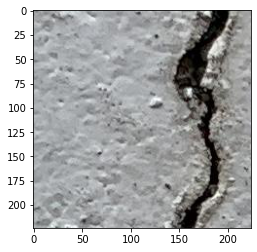


Sample no crack image:


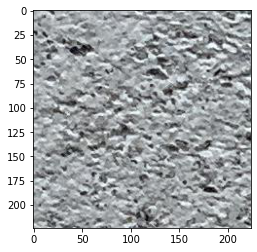

In [3]:
print("Sample crack image:")
plt.imshow(load_img(f"{os.path.join(train_positive_dir, os.listdir(train_positive_dir)[0])}"))
plt.show()

print("\nSample no crack image:")
plt.imshow(load_img(f"{os.path.join(train_negative_dir, os.listdir(train_negative_dir)[0])}"))
plt.show()

In [4]:
# Load the first example of a crack
sample_image  = load_img(f"{os.path.join(train_positive_dir, os.listdir(train_positive_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (224, 224, 3)


### As expected, the sample image has a resolution of 224x224 and the last dimension is used for each one of the RGB channels to represent color.

# Preprocessing the images

In [5]:
image_size = 150       #resize all images to 224*224

labels = ['Positive', 'Negative']          #labels from the folders

In [6]:
def create_training_data(data_dir):              #creating the training data
    
    images = []
    
    for label in labels:
        dir = os.path.join(data_dir,label)
        class_num = labels.index(label)
        
        for image in os.listdir(dir):    #going through all the images in different folders and resizing them
            
            image_read = cv.imread(os.path.join(dir,image),cv.IMREAD_COLOR)
            image_resized = cv.resize(image_read,(image_size,image_size))
            images.append([image_resized,class_num])
            
    return np.array(images)

In [7]:
train = create_training_data('/kaggle/input/surface-crack/train')
test = create_training_data('/kaggle/input/surface-crack/test')
valid = create_training_data('/kaggle/input/surface-crack/valid')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


### Loading the train and valid Images and Labels together

In [8]:
X = []
y = []

for feature, label in train:
    X.append(feature)          #appending all images
    y.append(label)            #appending all labels
X_valid = []
y_valid = []
for feature, label in valid:
    X_valid.append(feature)
    y_valid.append(label)

In [9]:
X_train = np.array(X).reshape(-1, image_size, image_size, 3)
y_train = np.array(y)
y_train = np.expand_dims(y_train, axis =1)

In [10]:
X_vald = np.array(X_valid).reshape(-1, image_size, image_size, 3)
y_vald = np.array(y_valid)
y_vald = np.expand_dims(y_vald, axis =1)

### Loading the test Images and Labels together

In [11]:
X_new = []
y_new = []

for feature, label in test:
    X_new.append(feature)          #appending all images
    y_new.append(label)            #appending all labels

In [12]:
X_test = np.array(X_new).reshape(-1, image_size, image_size, 3)
y_test = np.array(y_new)
y_test = np.expand_dims(y_test, axis =1)

In [13]:
X_train.shape

(600, 150, 150, 3)

In [14]:
y_train.shape

(600, 1)

In [15]:
X_train = X_train / 255            # normalizing
X_test = X_test / 255
X_vald = X_vald/ 255

# Transfer learning - Create the pre-trained model

### Download the inception V3 weights into the /tmp/ directory:

In [16]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-01-10 07:55:17--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 172.217.204.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  22.9MB/s    in 4.5s    

2023-01-10 07:55:22 (18.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



### Now load the InceptionV3 model and save the path to the weights we just downloaded:

In [17]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [18]:
# create_pre_trained_model
def create_pre_trained_model(local_weights_file):
    pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

    pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False

  ### END CODE HERE

    return pre_trained_model

# Compiling and viewing the model summary

In [19]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

2023-01-10 07:55:23.023226: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Pipelining the pre-trained model with your own

In [20]:
def output_of_last_layer(pre_trained_model):
    last_desired_layer = pre_trained_model.get_layer('mixed7')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output =  last_desired_layer.output
    print('last layer output: ', last_output)


    return last_output


In [21]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [22]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [23]:

def create_final_model(pre_trained_model, last_output):
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)

 

    # Add a fully connected layer with 512 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)
#     x = layers.Dense(512, activation='relu')(x)
#     # Add a dropout rate of 0.3
#     x = layers.Dropout(0.3)(x)
#     x = layers.Dense(512, activation='relu')(x)
#     # Add a dropout rate of 0.1
#     x = layers.Dropout(0.1)(x)
    # Add a final sigmoid layer for classification
    x = layers.Dense(1, activation='sigmoid')(x) 
    
    # Create the complete model by using the Model class
    model = Model(pre_trained_model.input, x)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate = 0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

    ### END CODE HERE
  
    return model

In [24]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


# Data Augmentation

In [25]:
batch_size = 4

train_gen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip = True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rescale=1.,
                                   zoom_range=0.2,
                                   fill_mode='nearest',
                                   cval=0)

train_generator = train_gen.flow(X_train,y_train,batch_size)
steps_per_epoch = X_train.shape[0]//batch_size

In [26]:
checkpoint = ModelCheckpoint('surface-crack', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [27]:
r = model.fit(train_generator, validation_data=(X_vald, y_vald), steps_per_epoch = steps_per_epoch, epochs= 15,
                       callbacks = [checkpoint])

2023-01-10 07:55:26.667893: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
150/150 [==============================] - 37s 215ms/step - loss: 0.4667 - accuracy: 0.8300 - val_loss: 0.1368 - val_accuracy: 0.9500

Epoch 00001: val_loss improved from inf to 0.13679, saving model to surface-crack


2023-01-10 07:56:17.346193: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/15
150/150 [==============================] - 31s 203ms/step - loss: 0.2253 - accuracy: 0.9167 - val_loss: 0.1458 - val_accuracy: 0.9550

Epoch 00002: val_loss did not improve from 0.13679
Epoch 3/15
150/150 [==============================] - 30s 199ms/step - loss: 0.2339 - accuracy: 0.9167 - val_loss: 0.1144 - val_accuracy: 0.9600

Epoch 00003: val_loss improved from 0.13679 to 0.11440, saving model to surface-crack
Epoch 4/15
150/150 [==============================] - 30s 201ms/step - loss: 0.2317 - accuracy: 0.9217 - val_loss: 0.1741 - val_accuracy: 0.9250

Epoch 00004: val_loss did not improve from 0.11440
Epoch 5/15
150/150 [==============================] - 30s 203ms/step - loss: 0.2059 - accuracy: 0.9200 - val_loss: 0.1087 - val_accuracy: 0.9550

Epoch 00005: val_loss improved from 0.11440 to 0.10871, saving model to surface-crack
Epoch 6/15
150/150 [==============================] - 31s 208ms/step - loss: 0.2144 - accuracy: 0.9383 - val_loss: 0.2360 - val_accuracy: 0.89

# Plots

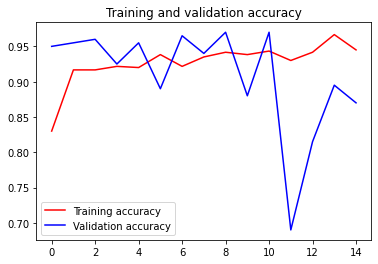

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

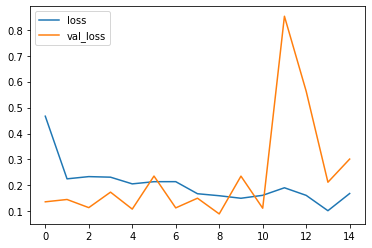

In [29]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [30]:
# new_model = tf.keras.models.load_model('surface-crack')   #loading model to train further

In [31]:
# new_model.compile(optimizer = Adam(learning_rate = 0.00001), loss = 'binary_crossentropy', metrics = ['accuracy']) 

# checkpoint1 = ModelCheckpoint('surface-crack', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# batch_size = 4

# r1 = new_model.fit(train_generator, validation_data=(X_vald, y_vald), steps_per_epoch = steps_per_epoch, epochs= 10,
#                        callbacks = [checkpoint1])

In [32]:
final_model = tf.keras.models.load_model('surface-crack')

In [33]:
pred = final_model.predict(X_test, batch_size = 8)
pred

array([[5.45163168e-08],
       [3.49607071e-05],
       [1.30604867e-05],
       [2.04188177e-06],
       [2.52552290e-09],
       [3.08310092e-07],
       [1.42902136e-04],
       [1.28551881e-06],
       [1.82228598e-06],
       [1.91916315e-05],
       [2.57715016e-07],
       [1.11591220e-02],
       [3.29199065e-05],
       [5.81236309e-05],
       [1.51260372e-06],
       [5.54504993e-08],
       [2.52261052e-05],
       [5.24010175e-05],
       [8.66302616e-06],
       [1.36926770e-03],
       [2.76422065e-06],
       [1.77790463e-01],
       [2.66071056e-05],
       [8.01350609e-07],
       [5.00635497e-06],
       [9.71904446e-05],
       [5.27164161e-08],
       [2.31196418e-06],
       [2.25400504e-06],
       [1.70357487e-06],
       [4.15644422e-07],
       [1.31233454e-01],
       [5.54792568e-05],
       [1.91753747e-06],
       [2.98998275e-05],
       [9.42615407e-06],
       [9.59315627e-10],
       [2.78681517e-04],
       [1.84197904e-06],
       [9.84060262e-06],


In [34]:
pred_final = np.where(pred>0.5,1,0)
pred_final

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

# Evaluating Metrics

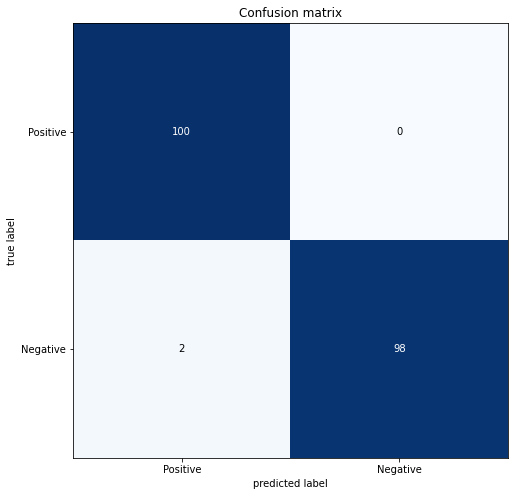

In [35]:
# Get the confusion matrix
CM = confusion_matrix(y_test, pred_final)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), ['Positive','Negative'], fontsize=10)
plt.yticks(range(2), ['Positive','Negative'], fontsize=10)
plt.show()

In [36]:
def perf_measure(y_test, pred_final):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(pred_final)): 
        if y_test[i]==pred_final[i]==1:
           TP += 1
        if y_test[i]==1 and y_test[i]!=pred_final[i]:
           FP += 1
        if y_test[i]==pred_final[i]==0:
           TN += 1
        if y_test[i]==0 and y_test[i]!=pred_final[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [37]:
tp, fp, tn ,fn = perf_measure(y_test,pred_final)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = (2*precision*recall)/(precision+recall)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F-Score is {:.2f}".format(f_score))

Recall of the model is 1.00
Precision of the model is 0.98
F-Score is 0.99
